# Задание 2.1 - Нейронные сети

В этом задании вы реализуете и натренируете настоящую нейроную сеть своими руками!

В некотором смысле это будет расширением прошлого задания - нам нужно просто составить несколько линейных классификаторов вместе!

<img src="https://i.redd.it/n9fgba8b0qr01.png" alt="Stack_more_layers" width="400px"/>

In [2]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

%load_ext autoreload
%autoreload 2

In [3]:
from dataset import load_svhn, random_split_train_val
from gradient_check import check_layer_gradient, check_layer_param_gradient, check_model_gradient
from layers import FullyConnectedLayer, ReLULayer
from model import TwoLayerNet
from trainer import Trainer, Dataset
from optim import SGD, MomentumSGD
from metrics import multiclass_accuracy

# Загружаем данные

И разделяем их на training и validation.

In [4]:
def prepare_for_neural_network(train_X, test_X):
    train_flat = train_X.reshape(train_X.shape[0], -1).astype(float) / 255.0
    test_flat = test_X.reshape(test_X.shape[0], -1).astype(float) / 255.0
    
    # Subtract mean
    mean_image = np.mean(train_flat, axis = 0)
    train_flat -= mean_image
    test_flat -= mean_image
    
    return train_flat, test_flat
    
train_X, train_y, test_X, test_y = load_svhn("data", max_train=10000, max_test=1000)    
train_X, test_X = prepare_for_neural_network(train_X, test_X)
# Split train into train and val
train_X, train_y, val_X, val_y = random_split_train_val(train_X, train_y, num_val = 1000)

# Как всегда, начинаем с кирпичиков

Мы будем реализовывать необходимые нам слои по очереди. Каждый слой должен реализовать:
- прямой проход (forward pass), который генерирует выход слоя по входу и запоминает необходимые данные
- обратный проход (backward pass), который получает градиент по выходу слоя и вычисляет градиент по входу и по параметрам

Начнем с ReLU, у которого параметров нет.

In [5]:
# TODO: Implement ReLULayer layer in layers.py
# Note: you'll need to copy implementation of the gradient_check function from the previous assignment

X = np.array([[1, -2, 3],
              [-1, 2, 0.1]
             ])

assert check_layer_gradient(ReLULayer(), X)

Gradient check passed!


А теперь реализуем полносвязный слой (fully connected layer), у которого будет два массива параметров: W (weights) и B (bias).

Все параметры наши слои будут использовать для параметров специальный класс `Param`, в котором будут храниться значения параметров и градиенты этих параметров, вычисляемые во время обратного прохода.

Это даст возможность аккумулировать (суммировать) градиенты из разных частей функции потерь, например, из cross-entropy loss и regularization loss.

In [6]:
# TODO: Implement FullyConnected layer forward and backward methods
assert check_layer_gradient(FullyConnectedLayer(3, 4), X)
# TODO: Implement storing gradients for W and B
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'W')
assert check_layer_param_gradient(FullyConnectedLayer(3, 4), X, 'B')

Gradient check passed!
Gradient check passed!
Gradient check passed!


## Создаем нейронную сеть

Теперь мы реализуем простейшую нейронную сеть с двумя полносвязным слоями и нелинейностью ReLU. Реализуйте функцию `compute_loss_and_gradients`, она должна запустить прямой и обратный проход через оба слоя для вычисления градиентов.

Не забудьте реализовать очистку градиентов в начале функции.

In [7]:
# TODO: In model.py, implement compute_loss_and_gradients function
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 0)
loss = model.compute_loss_and_gradients(train_X[:2], train_y[:2])

# TODO Now implement backward pass and aggregate all of the params
check_model_gradient(model, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Теперь добавьте к модели регуляризацию - она должна прибавляться к loss и делать свой вклад в градиенты.

In [40]:
# TODO Now implement l2 regularization in the forward and backward pass / done
model_with_reg = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 3, reg = 1e1)
loss_with_reg = model_with_reg.compute_loss_and_gradients(train_X[:2], train_y[:2])
assert loss_with_reg > loss and not np.isclose(loss_with_reg, loss), \
    "Loss with regularization (%2.4f) should be higher than without it (%2.4f)!" % (loss, loss_with_reg)

check_model_gradient(model_with_reg, train_X[:2], train_y[:2])

Checking gradient for 0_W
Gradient check passed!
Checking gradient for 0_B
Gradient check passed!
Checking gradient for 2_W
Gradient check passed!
Checking gradient for 2_B
Gradient check passed!


True

Также реализуем функцию предсказания (вычисления значения) модели на новых данных.

Какое значение точности мы ожидаем увидеть до начала тренировки?

In [41]:
# Finally, implement predict function!

# TODO: Implement predict function
# What would be the value we expect?
cut = 30
multiclass_accuracy(model_with_reg.predict(train_X[:cut]), train_y[:cut]) 

0.1

0.1 т.к. сеть еще нетренирована

# Допишем код для процесса тренировки

Если все реализовано корректно, значение функции ошибки должно уменьшаться с каждой эпохой, пусть и медленно. Не беспокойтесь пока про validation accuracy.

In [45]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.302179, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302471, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302430, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301512, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303168, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302886, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301959, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301672, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.301947, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.301506, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302411, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303155, Train accuracy: 0.148222, val accuracy: 0.140000
Loss: 2.300461, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302417, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302020, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302151, Train acc

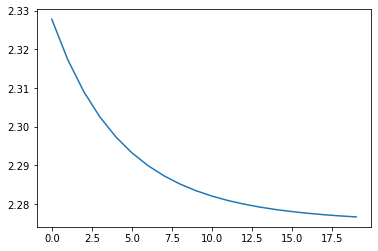

In [53]:
plt.plot(loss_history) # reg = 1e1

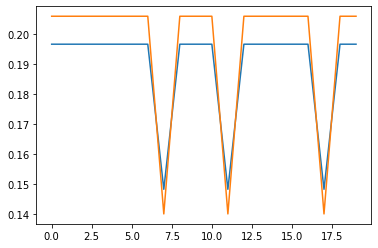

In [46]:
plt.plot(train_history)
plt.plot(val_history)

In [54]:
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate = 1e-2)

# TODO Implement missing pieces in Trainer.fit function
# You should expect loss to go down every epoch, even if it's slow
loss_history, train_history, val_history = trainer.fit()

Loss: 2.258686, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.244333, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311809, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.221708, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.254335, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.233961, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264054, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.236806, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.232168, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291203, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.254749, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.263166, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.255885, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293685, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.318229, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.320414, Train acc

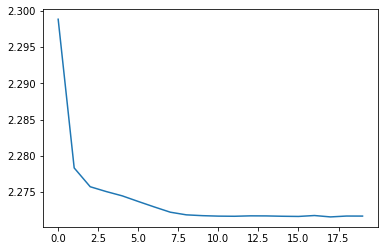

In [55]:
plt.plot(loss_history) # reg = 1e-1

# Улучшаем процесс тренировки

Мы реализуем несколько ключевых оптимизаций, необходимых для тренировки современных нейросетей.

## Уменьшение скорости обучения (learning rate decay)

Одна из необходимых оптимизаций во время тренировки нейронных сетей - постепенное уменьшение скорости обучения по мере тренировки.

Один из стандартных методов - уменьшение скорости обучения (learning rate) каждые N эпох на коэффициент d (часто называемый decay). Значения N и d, как всегда, являются гиперпараметрами и должны подбираться на основе эффективности на проверочных данных (validation data). 

В нашем случае N будет равным 1.

In [48]:
# TODO Implement learning rate decay inside Trainer.fit method
# Decay should happen once per epoch

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, SGD(), learning_rate_decay=0.99)

initial_learning_rate = trainer.learning_rate
loss_history, train_history, val_history = trainer.fit()

assert trainer.learning_rate < initial_learning_rate, "Learning rate should've been reduced"
assert trainer.learning_rate > 0.5*initial_learning_rate, "Learning rate shouldn'tve been reduced that much!"

Loss: 2.312288, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291717, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.233388, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.325706, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266505, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.287885, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.234362, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.298867, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.250137, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.230673, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.264709, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.319534, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296160, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.202986, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.268247, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.245171, Train acc

# Накопление импульса (Momentum SGD)

Другой большой класс оптимизаций - использование более эффективных методов градиентного спуска. Мы реализуем один из них - накопление импульса (Momentum SGD).

Этот метод хранит скорость движения, использует градиент для ее изменения на каждом шаге, и изменяет веса пропорционально значению скорости.
(Физическая аналогия: Вместо скорости градиенты теперь будут задавать ускорение, но будет присутствовать сила трения.)

```
velocity = momentum * velocity - learning_rate * gradient 
w = w + velocity
```

`momentum` здесь коэффициент затухания, который тоже является гиперпараметром (к счастью, для него часто есть хорошее значение по умолчанию, типичный диапазон -- 0.8-0.99).

Несколько полезных ссылок, где метод разбирается более подробно:  
http://cs231n.github.io/neural-networks-3/#sgd  
https://distill.pub/2017/momentum/

In [52]:
# TODO: Implement MomentumSGD.update function in optim.py

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X, train_y, val_X, val_y)
trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=1e-4, learning_rate_decay=0.99)

# You should see even better results than before!
loss_history, train_history, val_history = trainer.fit()

Loss: 2.322305, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.311387, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314741, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.278735, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.296309, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.281188, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302904, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266983, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.303570, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.250594, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.242851, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.314148, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.270378, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.272375, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289814, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.318401, Train acc

# Ну что, давайте уже тренировать сеть!

## Последний тест - переобучимся (overfit) на маленьком наборе данных

Хороший способ проверить, все ли реализовано корректно - переобучить сеть на маленьком наборе данных.  
Наша модель обладает достаточной мощностью, чтобы приблизить маленький набор данных идеально, поэтому мы ожидаем, что на нем мы быстро дойдем до 100% точности на тренировочном наборе. 

Если этого не происходит, то где-то была допущена ошибка!

In [56]:
data_size = 15
model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 100, reg = 1e-1)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=150, batch_size=5)

# You should expect this to reach 1.0 training accuracy 
loss_history, train_history, val_history = trainer.fit()

Loss: 2.342947, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.327294, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.319175, Train accuracy: 0.266667, val accuracy: 0.066667
Loss: 2.295347, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.329013, Train accuracy: 0.200000, val accuracy: 0.066667
Loss: 2.313219, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.288857, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.265575, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.170869, Train accuracy: 0.266667, val accuracy: 0.000000
Loss: 2.243902, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.425670, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.068425, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 2.259986, Train accuracy: 0.400000, val accuracy: 0.000000
Loss: 1.988161, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.755596, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.841644, Train acc

Loss: 1.531349, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.204345, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.317537, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.571304, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.247622, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.154777, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.118432, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.547839, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.224763, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.177402, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.196507, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.328412, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.205139, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.273195, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.333303, Train accuracy: 1.000000, val accuracy: 0.000000
Loss: 1.181558, Train acc

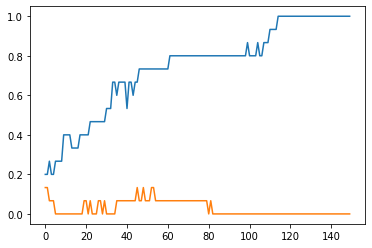

In [58]:
plt.plot(train_history)
plt.plot(val_history)

Теперь найдем гипепараметры, для которых этот процесс сходится быстрее.
Если все реализовано корректно, то существуют параметры, при которых процесс сходится в **20** эпох или еще быстрее.
Найдите их!

In [61]:
# Now, tweak some hyper parameters and make it train to 1.0 accuracy in 20 epochs or less

model = TwoLayerNet(n_input = train_X.shape[1], n_output = 10, hidden_layer_size = 300, reg = 1e-6)
dataset = Dataset(train_X[:data_size], train_y[:data_size], val_X[:data_size], val_y[:data_size])
# TODO: Change any hyperparamers or optimizators to reach training accuracy in 20 epochs
trainer = Trainer(model, dataset, SGD(), learning_rate=1e-1, num_epochs=20, batch_size=10)

loss_history, train_history, val_history = trainer.fit()

Loss: 2.306993, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.306542, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.311317, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.282121, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.291764, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.299321, Train accuracy: 0.200000, val accuracy: 0.133333
Loss: 2.246900, Train accuracy: 0.266667, val accuracy: 0.133333
Loss: 2.202207, Train accuracy: 0.333333, val accuracy: 0.133333
Loss: 2.247609, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.263394, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 1.955495, Train accuracy: 0.333333, val accuracy: 0.066667
Loss: 2.082357, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.026174, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.910305, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 2.001560, Train accuracy: 0.333333, val accuracy: 0.000000
Loss: 1.546661, Train acc

ez :)

# Итак, основное мероприятие!

Натренируйте лучшую нейросеть! Можно добавлять и изменять параметры, менять количество нейронов в слоях сети и как угодно экспериментировать. 

Добейтесь точности лучше **60%** на validation set.

In [63]:
# Let's train the best one-hidden-layer network we can

learning_rates = [1e-1, 1e-2, 1e-3]
reg_strength = [1e-3, 1e-5]
hidden_layer_sizes = [32, 64, 128]
num_epochs = 16
batch_size = [64, 128, 256]

best_classifier = None
best_val_accuracy = 0

loss_history = []
train_history = []
val_history = []

dataset = Dataset(train_X, train_y, val_X, val_y)

for lr in learning_rates:
    for rs in reg_strength:
        for ls in hidden_layer_sizes:
            for bs in batch_size:
                model = TwoLayerNet(n_input=train_X.shape[1], n_output=10, hidden_layer_size=ls, reg=rs)
                trainer = Trainer(model, dataset, MomentumSGD(), learning_rate=lr, num_epochs=num_epochs, batch_size=bs)
                temp_loss_history, temp_train_history, temp_val_history = trainer.fit()
                
                if temp_val_history[-1] > best_val_accuracy:
                    best_classifier = model
                    best_val_accuracy = temp_val_history[-1]
                    loss_history = temp_loss_history.copy()
                    train_history = temp_train_history.copy()
                    val_history = temp_val_history.copy()

print('best validation accuracy achieved: %f' % best_val_accuracy)

Loss: 2.085371, Train accuracy: 0.280667, val accuracy: 0.294000
Loss: 1.889977, Train accuracy: 0.534444, val accuracy: 0.535000
Loss: 1.839774, Train accuracy: 0.536333, val accuracy: 0.533000
Loss: 1.317168, Train accuracy: 0.597111, val accuracy: 0.585000
Loss: 1.775746, Train accuracy: 0.576444, val accuracy: 0.540000
Loss: 1.403891, Train accuracy: 0.640889, val accuracy: 0.623000
Loss: 1.456794, Train accuracy: 0.505444, val accuracy: 0.495000
Loss: 1.721392, Train accuracy: 0.622889, val accuracy: 0.599000
Loss: 1.462135, Train accuracy: 0.623111, val accuracy: 0.607000
Loss: 1.491735, Train accuracy: 0.615556, val accuracy: 0.603000
Loss: 1.324080, Train accuracy: 0.584889, val accuracy: 0.580000
Loss: 1.872231, Train accuracy: 0.606778, val accuracy: 0.570000
Loss: 1.338626, Train accuracy: 0.599111, val accuracy: 0.571000
Loss: 1.671178, Train accuracy: 0.610111, val accuracy: 0.586000
Loss: 1.792070, Train accuracy: 0.658111, val accuracy: 0.599000
Loss: 1.332083, Train acc

Loss: 1.326794, Train accuracy: 0.745333, val accuracy: 0.671000
Loss: 2.369182, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.153578, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 1.932451, Train accuracy: 0.315444, val accuracy: 0.308000
Loss: 1.386038, Train accuracy: 0.468778, val accuracy: 0.480000
Loss: 1.833498, Train accuracy: 0.567667, val accuracy: 0.550000
Loss: 1.416159, Train accuracy: 0.612222, val accuracy: 0.591000
Loss: 1.010940, Train accuracy: 0.642444, val accuracy: 0.616000
Loss: 1.193727, Train accuracy: 0.674333, val accuracy: 0.649000
Loss: 1.039691, Train accuracy: 0.682444, val accuracy: 0.655000
Loss: 1.138693, Train accuracy: 0.715222, val accuracy: 0.675000
Loss: 0.890887, Train accuracy: 0.714778, val accuracy: 0.667000
Loss: 1.081460, Train accuracy: 0.730556, val accuracy: 0.690000
Loss: 0.867858, Train accuracy: 0.724778, val accuracy: 0.682000
Loss: 1.146025, Train accuracy: 0.762556, val accuracy: 0.715000
Loss: 0.992510, Train acc

Loss: 0.555405, Train accuracy: 0.764556, val accuracy: 0.677000
Loss: 0.836187, Train accuracy: 0.770556, val accuracy: 0.676000
Loss: 2.184826, Train accuracy: 0.197667, val accuracy: 0.207000
Loss: 1.798236, Train accuracy: 0.469889, val accuracy: 0.460000
Loss: 1.338434, Train accuracy: 0.567222, val accuracy: 0.572000
Loss: 1.396033, Train accuracy: 0.655000, val accuracy: 0.622000
Loss: 1.334568, Train accuracy: 0.683778, val accuracy: 0.647000
Loss: 1.213492, Train accuracy: 0.718111, val accuracy: 0.679000
Loss: 1.271001, Train accuracy: 0.704778, val accuracy: 0.672000
Loss: 1.151588, Train accuracy: 0.747000, val accuracy: 0.697000
Loss: 0.745910, Train accuracy: 0.771667, val accuracy: 0.699000
Loss: 1.026044, Train accuracy: 0.771111, val accuracy: 0.707000
Loss: 1.195865, Train accuracy: 0.749333, val accuracy: 0.675000
Loss: 1.367669, Train accuracy: 0.809667, val accuracy: 0.730000
Loss: 1.038802, Train accuracy: 0.817222, val accuracy: 0.708000
Loss: 0.723976, Train acc

Loss: 2.118720, Train accuracy: 0.223000, val accuracy: 0.235000
Loss: 2.025859, Train accuracy: 0.245889, val accuracy: 0.245000
Loss: 2.085896, Train accuracy: 0.257111, val accuracy: 0.256000
Loss: 2.170185, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.140572, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.245891, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.211341, Train accuracy: 0.258111, val accuracy: 0.256000
Loss: 2.123576, Train accuracy: 0.332889, val accuracy: 0.340000
Loss: 1.735611, Train accuracy: 0.425556, val accuracy: 0.423000
Loss: 1.387711, Train accuracy: 0.491000, val accuracy: 0.479000
Loss: 1.595095, Train accuracy: 0.546778, val accuracy: 0.530000
Loss: 1.511556, Train accuracy: 0.595556, val accuracy: 0.577000
Loss: 1.300073, Train accuracy: 0.618778, val accuracy: 0.606000
Loss: 1.066773, Train accuracy: 0.650111, val accuracy: 0.645000
Loss: 1.244735, Train accuracy: 0.667444, val accuracy: 0.657000
Loss: 1.095630, Train acc

Loss: 1.674075, Train accuracy: 0.440778, val accuracy: 0.441000
Loss: 1.702504, Train accuracy: 0.481000, val accuracy: 0.477000
Loss: 1.446856, Train accuracy: 0.510333, val accuracy: 0.493000
Loss: 1.434075, Train accuracy: 0.544444, val accuracy: 0.537000
Loss: 2.281320, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.220668, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.192075, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.184656, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.199589, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.211030, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.193772, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.220926, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.165796, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.149351, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.234764, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.048806, Train acc

Loss: 2.215391, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.273503, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.210191, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.331297, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.231559, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.293633, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.297636, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.267388, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.306556, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.271607, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.250433, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.258417, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.231248, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.230065, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.292493, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.248794, Train acc

Loss: 2.278651, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.266730, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.223498, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.302354, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.242141, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.274091, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.291769, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.223667, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.228691, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.330384, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.231341, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.247380, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.289626, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.323267, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.299766, Train accuracy: 0.196667, val accuracy: 0.206000
Loss: 2.277934, Train acc

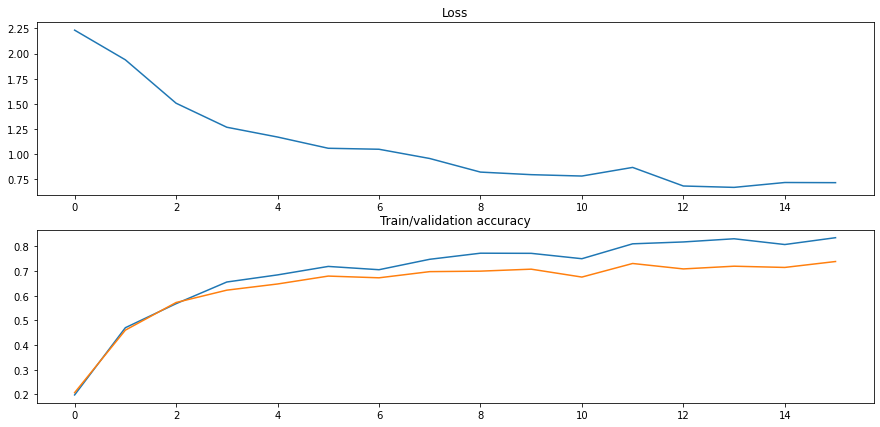

In [64]:
plt.figure(figsize=(15, 7))
plt.subplot(211)
plt.title("Loss")
plt.plot(loss_history)
plt.subplot(212)
plt.title("Train/validation accuracy")
plt.plot(train_history)
plt.plot(val_history)

# Как обычно, посмотрим, как наша лучшая модель работает на тестовых данных

In [65]:
test_pred = best_classifier.predict(test_X)
test_accuracy = multiclass_accuracy(test_pred, test_y)
print('Neural net test set accuracy: %f' % (test_accuracy, ))

Neural net test set accuracy: 0.699000
